In [2]:
import pandas as pd
import numpy as np
import random

import gym
from gym.spaces import Discrete, Box, Dict

from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDRegressor

In [3]:
class Estimator():
    """
    Value Function approximator
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space["consumption"].n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([np.array(list(env.reset().get("wealth_bucket")))], [0])
            self.models.append(model)
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        if not a:
            return np.array([m.predict([s])[0] for m in self.models])
        else:
            return self.models[a].predict([s])[0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        self.models[a].partial_fit([s], [y])

https://github.com/dennybritz/reinforcement-learning/blob/master/FA/Q-Learning%20with%20Value%20Function%20Approximation%20Solution.ipynb

To estimate the income profile of our agent we used the data from the UK office of statsitiscs.

A few datapoints were provided:

18-21   17,849
22-29   26,021
30-39   32,994
40-49   35,846
50-59   33,336
60+	    8,848

By interpolating a cubic function we could define a function able to provide income per age.

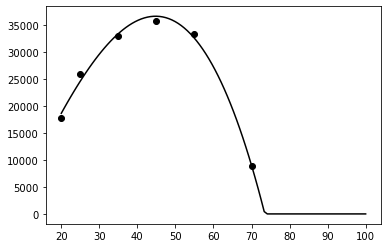

In [30]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


# whole range we want to plot
x_plot = np.linspace(20, 100, 100)

x_train = np.array([20, 25, 35, 45, 55, 70])
rng = np.random.RandomState(0)
y_train = [17849, 26021, 32994, 35846, 33336, 8848]

# plot function
fig, ax = plt.subplots()
ax.set_prop_cycle(
    color=["black", "teal", "yellowgreen", "gold", "darkorange", "tomato"]
)


# plot training points
ax.scatter(x_train, y_train, label="training points")


model = make_pipeline(PolynomialFeatures(3), Ridge(alpha=1e-3))
model.fit(x_train.reshape(-1, 1), y_train)
y_plot = model.predict(x_plot.reshape(-1, 1))
y_plot[y_plot < 0] = 0
ax.plot(x_plot, y_plot, label="degree 3")

In [27]:
class LifecycleEnv(gym.Env):
    def __init__(self):
        # Here we define the choices on consumption and equity allocation
        self.action_space = Dict({"equity_allocation": Discrete(6),
                                  "consumption": Discrete(190)})
        # Set starting variables
        self.wealth = 100
        self.starting_income = 100
        self.income = self.starting_income
        self.starting_age = 19
        self.age = self.starting_age
        self.retirement_age = 65
        self.terminal_age = 115
        self.max_wealth = 10000
        self.wealth_buckets = 500
        # Here we create our observation space
        self.observation_space = Dict({"age": Discrete(self.terminal_age - self.starting_age + 1), "wealth_bucket": Discrete(self.wealth_buckets)})

    def step(self, action):
        reward = 0
        # Income reduces when you retire
        if self.age >= self.retirement_age:
            self.income = 0
        # define market returns
        risk_return = 0.05
        risk_free_return = 0.01
        # transformation
        # print(action)
        action_equity_allocation = action["equity_allocation"] / 5
        action_consumption = action["consumption"] + 10
        # Apply action
        # print(action_equity_allocation)
        portfolio_return = (risk_return * \
            action_equity_allocation) + (risk_free_return * \
            (1 - action_equity_allocation))
        start_wealth = self.wealth
        # Here income is added only after the portfolio return
        self.wealth = (1 + portfolio_return) * (self.wealth -
                                                action_consumption) + self.income
        if self.wealth < 0:
            self.wealth = 0
            reward += -10000
            done = True
        reward += action_consumption
        # Complete step if agent is older than terminal age
        if self.age == self.terminal_age:
            done = True
            reward = 0
        else:
            done = False
        # Time passes (philosophical consideration here)
        self.age += 1
        # Placeholder for info
        info = {"age": self.age, "start_wealth": start_wealth, "wealth": self.wealth, 
                "consumption": action_consumption, "equity_allocation": action_equity_allocation, "port_return": portfolio_return}
        state = {"age": self.age, "wealth_bucket": min(int(self.wealth/(self.max_wealth + 1) * self.wealth_buckets), self.wealth_buckets - 1)}
        return state, reward, done, info

    def render(self, mode='human'):
        # no urgent need for this
        pass

    def reset(self):
        # Resetting age and wealth
        self.wealth = 100
        self.age = self.starting_age
        self.income = self.starting_income
        state = {"age": self.age, "wealth_bucket": int(self.wealth/self.max_wealth)}
        return state


env = LifecycleEnv()
# Observation and action space
print("The observation space: {}".format(env.observation_space))
print("The action space: {}".format(env.action_space))


The observation space: Dict(age: Discrete(97), wealth_bucket: Discrete(500))
The action space: Dict(consumption: Discrete(190), equity_allocation: Discrete(6))


In [28]:
# Hyperparameters
minutes = 60
epochs =  int(minutes * 25000)
num_steps = env.terminal_age - env.starting_age + 1
epsilon = 1.0
# when using 0.9 the agent would be much worse at learning from negative rewards as it's kind of "accepting" them
learning_rate = 0.5
discount_rate = 0.9
decay_rate = 0.00001

# env setup
state = env.reset()
best_action = OrderedDict()
# my q table consist of 2 state actions and 2 observation spaces
# I need to change one of the observation space variables into a continuos one and use function approximation
q_table = np.zeros([env.observation_space["age"].n, env.observation_space["wealth_bucket"].n, 
    env.action_space["equity_allocation"].n, env.action_space["consumption"].n])

for epoch in range(epochs):
    state = env.reset()
    done = False
    if (epoch + 1) % 10000 == 0:
        rewards = 0
        for step in range(num_steps):
            q = q_table[state["age"] - env.starting_age, state["wealth_bucket"]]
            best_action['equity_allocation'] = np.unravel_index(np.argmax(q, axis=None), q.shape)[0]
            best_action['consumption'] = np.unravel_index(np.argmax(q, axis=None), q.shape)[1]
            new_state, reward, done, info = env.step(best_action)
            rewards += reward
            state = new_state
        print("In epoch " + str(epoch+1) + " the reward is " + str(rewards) + ". The current epsilon used is " + str(round(epsilon, 2)) + ".")
        state = env.reset()
        done = False

    for step in range(num_steps):
        # take random action
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            # here I select the best action based on my q table
            q = q_table[state["age"] - env.starting_age, state["wealth_bucket"]]
            max_q_index = np.unravel_index(np.argmax(q, axis=None), q.shape)
            best_action['equity_allocation'] = max_q_index[0]
            best_action['consumption'] = max_q_index[1]
            action = best_action  # Exploit learned values

        # apply the action
        next_state, reward, done, info = env.step(action)
        if done == True:
            break
        # Update the q table
        # print(q_table.shape)
        # print(state["wealth_bucket"])
        old_value = q_table[state["age"] - env.starting_age, state["wealth_bucket"], action["equity_allocation"], action["consumption"]]
        next_max = np.max(q_table[next_state["age"] - env.starting_age, next_state["wealth_bucket"]])
        new_value = (1 - learning_rate) * old_value + learning_rate * (reward + discount_rate * next_max)
        q_table[state["age"] - env.starting_age, state["wealth_bucket"], action["equity_allocation"], action["consumption"]] = new_value

        # If the episode is up, then start another one
        state = next_state
    # this is a greedy implementation
    epsilon = np.exp(-decay_rate * epoch)
    # epsilon = 1 - (epoch / epochs)

# Close the env
env.close()


In epoch 10000 the reward is -490457. The current epsilon used is 0.9.
In epoch 20000 the reward is -479904. The current epsilon used is 0.82.
In epoch 30000 the reward is -479537. The current epsilon used is 0.74.
In epoch 40000 the reward is -459691. The current epsilon used is 0.67.
In epoch 50000 the reward is -449147. The current epsilon used is 0.61.
In epoch 60000 the reward is -459139. The current epsilon used is 0.55.
In epoch 70000 the reward is -448348. The current epsilon used is 0.5.
In epoch 80000 the reward is -447897. The current epsilon used is 0.45.
In epoch 90000 the reward is -428378. The current epsilon used is 0.41.
In epoch 100000 the reward is -437442. The current epsilon used is 0.37.
In epoch 110000 the reward is -426980. The current epsilon used is 0.33.
In epoch 120000 the reward is -466243. The current epsilon used is 0.3.
In epoch 130000 the reward is -416939. The current epsilon used is 0.27.
In epoch 140000 the reward is -406978. The current epsilon used

In [29]:
# watch trained agent
state = env.reset()
done = False
rewards = 0
info_df = pd.DataFrame(
    columns=("age", "start_wealth", "wealth", "consumption", "equity_allocation", "port_return"))

for step in range(num_steps):
    q = q_table[state["age"] - env.starting_age, state["wealth_bucket"]]
    max_q_index = np.unravel_index(np.argmax(q, axis=None), q.shape)
    best_action['equity_allocation'] = max_q_index[0]
    best_action['consumption'] = max_q_index[1]
    new_state, reward, done, info = env.step(best_action)
    info_df = info_df.append(info, ignore_index=True) 
    rewards += reward
    state = new_state
print(rewards)

5053


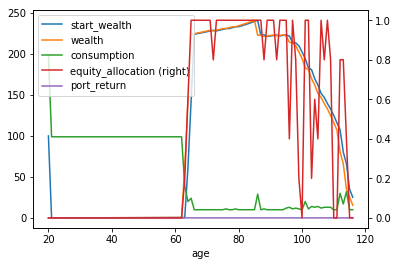

In [30]:
# print(info_df.set_index("age"))
info_df.set_index("age").plot(secondary_y=["equity_allocation"])

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)


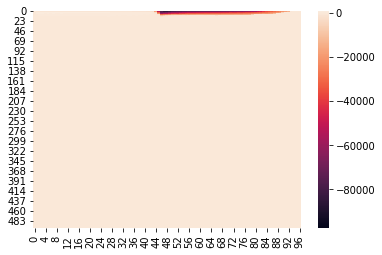

In [31]:
sns.heatmap(pd.DataFrame(q_table.mean(axis=3).mean(axis=2)).T)

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)


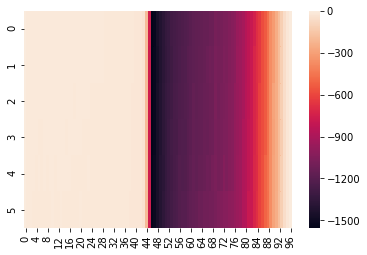

In [32]:
sns.heatmap(pd.DataFrame(q_table.mean(axis=3).mean(axis=1)).T)

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)


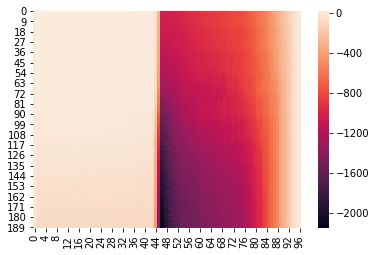

In [33]:
sns.heatmap(pd.DataFrame(q_table.mean(axis=1).mean(axis=1)).T)